In [18]:
pathToModels = "D:\\models\\python\\"
pathToTests = "D:\\modelTests\\"
import pickle
import keras
import tensorflow as tf
from keras.models import load_model
from keras.preprocessing import image
from keras_preprocessing.sequence import pad_sequences
import numpy as np
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt

# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()
        
def searchFiles(path, fileformats):
    filesToDo = []
    for root, dirs, files in os.walk(path):
        for file in files:
            for fileformat in fileformats:
                if file.endswith(fileformat):
                    #code to generate a list of paths of files to generate logs for
                    filesToDo.append(os.path.join(root, file).removeprefix(path))
    return filesToDo

def searchFileName(path, fileName):
    filesToDo = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == fileName:
                #code to generate a list of paths of files to generate logs for
                filesToDo.append(os.path.join(root, file).removeprefix(path))
    return filesToDo





In [2]:
"Text Processing"
"Up to date with model creation since 11/18/22"

def stringProcessing(string):
    string = string.replace('    ', '\t')
    string = string.replace("\"\"\"" , "\"")
    string = string.replace("\'\'\'" , "\"")
    string = string.replace("\\'" , "")
    string = string.replace('\\"' , "")
    string = re.sub("('|\")[\x1f-\x7e]{1,}?('|\")", " \"sGH\"", string)
    string = re.sub("#.*", "", string)
    return string


to_pad = ['\n', '\t', '\r', '(', ')', '[', ']', '{', '}', '<', '>', '!', '?', ',', '.', ':', ';', '`', '~', '@', '#', '$', '%', '^', '&', '*', '=', '+', '/', '\\', '|']

def stringPadding(dataSet):
    if (type(dataSet) == str):
        for i in range(len(to_pad)):
            dataSet = dataSet.replace(to_pad[i], ' ' + to_pad[i] + ' ')
        return dataSet

In [6]:
#load 1 model
modelName = "python_model_1_IMPROVED"
model = load_model(pathToModels + modelName + '\\model.h5')
model.summary()
import pickle
with open(pathToModels + modelName + '\\tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
with open(pathToModels + modelName + '\\modelInfo.json') as json_file:
    modelInfo = json.load(json_file)
    modelInfo = {**modelInfo, **{"modelName": modelName}}


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 2000)       2002000   
                                                                 
 conv1d (Conv1D)             (None, 9997, 256)         2048256   
                                                                 
 conv1d_1 (Conv1D)           (None, 9994, 256)         262400    
                                                                 
 flatten (Flatten)           (None, 2558464)           0         
                                                                 
 dense (Dense)               (None, 128)               327483520 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 331,796,305
Trainable params: 331,796,305


In [49]:
"load Array of models"
modelNames = ["python_model_1", "python_model_1_IMPROVED"]
models = []
tokenizers = []
modelInfos = []
for modelName in modelNames:
    model = load_model(pathToModels + modelName + '/model.h5')
    models.append(model)
    with open(pathToModels + modelName + '/tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
        tokenizers.append(tokenizer)
    with open(pathToModels + modelName + '/modelInfo.json') as json_file:
        modelInfo = json.load(json_file)
        #add the model name
        modelInfo = {**modelInfo, **{"modelName": modelName}}
        modelInfos.append(modelInfo)

In [56]:
"Test Models"

"""Folder definition for Model Testing:
FOLDER:
testInfo.json (Contains the type of test and information for each file. See below)
testCode
"""

"""Types of test: 
Pos Linear comparative (PosLinCar): Each sequential file is expected to score higher than the last. Files are named 0.txt, 1.txt, 2.txt, etc.
Neutral (Neutral): Each file is expected to score about the same. Files are named 0.txt, 1.txt, 2.txt, etc.

"""



def modelTesting(modell, tokenizerl, modelInfol, testFolder): 
    with open(testFolder + '\\testInfo.json') as json_file:
        testInfo = json.load(json_file)
    #Check if model is an array of models
    if (type(modell) == list):
        for i in range(len(modell)):
            modelTestingRunner(modell[i], tokenizerl[i], modelInfol[i], testFolder, testInfo)
    else:
        modelTestingRunner(modell, tokenizerl, modelInfol, testFolder, testInfo)
        
def modelTestingRunner(modell, tokenizerl, modelInfol, testFolder, testInfo):
    print ("Testing " + modelInfol["modelName"])
    if testInfo['type'] == 'LinCar':
        posLinCarTest(modell, tokenizerl, modelInfol, testFolder)
    if testInfo['type'] == 'Neutral':
        neutralTest(modell, tokenizerl, modelInfol, testFolder)
    #Check if model is an array of models

    
def posLinCarTest(modell, tokenizerl, modelInfo1, testFolder):
    #load testInfo.json
    scores = []
    #load testCode
    filesToLoad = searchFiles(testFolder, ['.py'])
    for file in filesToLoad:
        with open(testFolder + file) as f:
            code = f.read()
            code = stringProcessing(code)
            code = stringPadding(code)
            code = tokenizerl.texts_to_sequences([code])
            code = pad_sequences(code, maxlen=modelInfo1['maxLen'])
            score = modell.predict(code)
            scores = np.append(scores, score)
            
    scoresDelta = []
    for i in range(len(scores) - 1):
        scoresDelta = np.append(scoresDelta, scores[i + 1] - scores[i])
    print (scores)
    print (scoresDelta)
    print ("expected outcome, scores should go up as the files go up, scoresDeltas should be positive")
    #graph scores in a scatter plot 
    plt.scatter(range(len(scores)), scores, label=modelInfo1['modelName'])
    plt.legend()
    plt.show()
    plt.scatter(range(len(scoresDelta)), scoresDelta, label=modelInfo1['modelName']+ " Delta")
    plt.legend()
    plt.show()

    
def neutralTest(modell, tokenizerl, modelInfo1, testFolder):
    scores = []
    #load testCode
    filesToLoad = searchFiles(testFolder, ['.py'])
    for file in filesToLoad:
        with open(testFolder + file) as f:
            code = f.read()
            code = stringProcessing(code)
            code = stringPadding(code)
            code = tokenizerl.texts_to_sequences([code])
            code = pad_sequences(code, maxlen=modelInfo1['maxLen'])
            score = modell.predict(code)
            scores = np.append(scores, score)
            
    scoresDelta = []
    for i in range(len(scores) - 1):
        scoresDelta = np.append(scoresDelta, scores[i + 1] - scores[i])
    print (scores)
    print (scoresDelta)
    print ("Biggest Score Delta: " + str(max(scoresDelta)))
    print ("expected outcome, scores should be about the same, scoresDeltas should be about the same")
    #graph scores in a scatter plot, label the score the model name
    plt.scatter(range(len(scores)), scores, label=modelInfo1['modelName'])
    plt.legend()
    plt.show()
    plt.scatter(range(len(scoresDelta)), scoresDelta, label=modelInfo1['modelName']+ " Delta")
    plt.legend()
    plt.show()

    

{'maxWords': 1000, 'maxLen': 10000, 'modelName': 'python_model_1_IMPROVED'}
Testing python_model_1
1/1 [==============================] - 1s 687ms/step
[54.54732513 52.54072189]
[-2.00660324]
expected outcome, scores should go up as the files go up, scoresDeltas should be positive


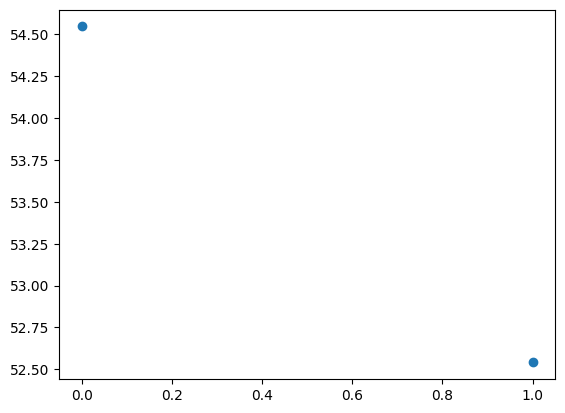

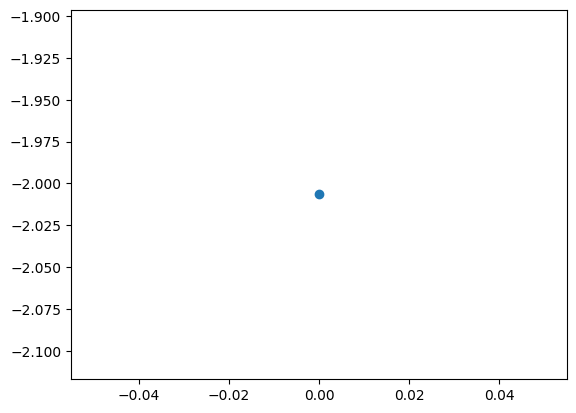

Testing python_model_1_IMPROVED
1/1 [==============================] - 1s 642ms/step
[24.94569588 27.18945694]
[2.24376106]
expected outcome, scores should go up as the files go up, scoresDeltas should be positive


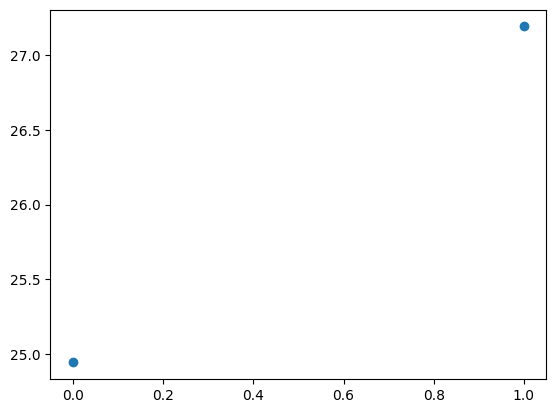

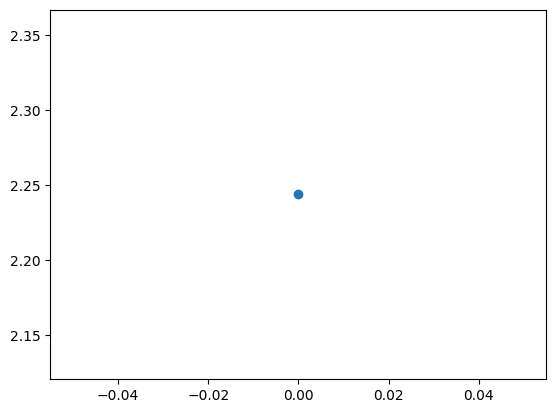

In [57]:
"temp testing stuff"
print (modelInfo)
modelTesting(models, tokenizers, modelInfos, pathToTests + 'dummyTestLinCar')
